In [2]:
from google.colab import files
import os

# Upload kaggle.json manually — this is our Kaggle API token to access datasets
uploaded = files.upload()

# Create the directory where Kaggle expects the token to be stored
os.makedirs("/root/.kaggle", exist_ok=True)

# Save the uploaded token in the correct location
with open("/root/.kaggle/kaggle.json", "wb") as f:
    f.write(uploaded['kaggle.json'])

# Set permissions so that only the owner can read/write it — required by Kaggle
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
# Download the dataset using the Kaggle CLI
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Unzip the dataset into a directory
!unzip -q covid19-radiography-database.zip -d covid19-radiography-dataset


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 83% 647M/778M [00:00<00:00, 1.36GB/s]
100% 778M/778M [00:00<00:00, 1.35GB/s]


# train test split images with mask

In [4]:
import os, shutil, random
from pathlib import Path

random.seed(42)  # For reproducibility of data splits

# Define source path and destination paths
source_dir = Path("/content/covid19-radiography-dataset/COVID-19_Radiography_Dataset")
dest_dir = Path("/content/data/processed")

# Separate training and test sets
train_dir = dest_dir / "train_data_with_masks"
test_dir = dest_dir / "test_data_with_masks"

# Class labels we're working with
classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
split_ratio = 0.85  # 85% training, 15% testing

for cls in classes:
    images_path = source_dir / cls / "images"
    masks_path = source_dir / cls / "masks"

    # Get all image filenames and shuffle for randomness
    images = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    # Split into train and test
    split_idx = int(len(images) * split_ratio)
    train_imgs, test_imgs = images[:split_idx], images[split_idx:]

    for subset, img_list in [('train', train_imgs), ('test', test_imgs)]:
        img_dest = (train_dir if subset == 'train' else test_dir) / cls / 'images'
        mask_dest = (train_dir if subset == 'train' else test_dir) / cls / 'masks'

        # Create folders if they don’t exist
        img_dest.mkdir(parents=True, exist_ok=True)
        mask_dest.mkdir(parents=True, exist_ok=True)

        # Copy images and corresponding masks (if they exist)
        for img in img_list:
            shutil.copy(images_path / img, img_dest / img)
            mask_path = masks_path / img
            if mask_path.exists():
                shutil.copy(mask_path, mask_dest / img)


# Train validation split + preprocessing










In [7]:
import tensorflow as tf
import numpy as np
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
import albumentations as A

# Constants (modify as needed)
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Make sure these exist in our code
# CLASSES = [...]
# CLASS_TO_INDEX = {...}
# DATA_DIR = Path("/your/data/path")
# augment = albumentations.Compose(...)  # assuming Albumentations is used


# Config
IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE = 224, 224, 16
CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(CLASSES)}
DATA_DIR = Path("/content/data/processed/train_data_with_masks")

# Albumentations augmentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])


def build_file_list(data_root):
    image_paths, mask_paths, labels = [], [], []
    for cls in CLASSES:
        img_dir = Path(data_root) / cls / "images"  # Image directory for each class
        mask_dir = Path(data_root) / cls / "masks"  # Mask directory for each class
        for img_file in img_dir.glob("*"):  # Iterate over all image files
            image_paths.append(str(img_file))  # Store image file path
            mask_paths.append(str(mask_dir / img_file.name))  # Store corresponding mask path
            labels.append(CLASS_TO_INDEX[cls])  # Store class label (numerical)
    return image_paths, mask_paths, labels  # Return lists of paths and labels


all_img_paths, all_mask_paths, all_labels = build_file_list(DATA_DIR)  # Load all file paths and labels

# Split the data into training and validation subsets
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths, train_labels_mask, val_labels_mask = train_test_split(
    all_img_paths, all_mask_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)
# test_size=0.2 → 20% for validation
# stratify=all_labels → ensures class distribution is preserved

# Determine minority classes for targeted augmentation
class_counts_mask = Counter(train_labels_mask)  # Count frequency of each class in training set
mean_count = np.mean(list(class_counts_mask.values()))  # Compute average class frequency

# Find classes with fewer samples than the mean
minority_classes_mask = [cls for cls, count in class_counts_mask.items() if count < mean_count]


def load_and_preprocess(img_path, mask_path, label, augment_on=False):
    def _load_numpy(img_path_str, mask_path_str, label_int, apply_aug):
        # Read grayscale image and mask using OpenCV
        img = cv2.imread(img_path_str.decode(), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path_str.decode(), cv2.IMREAD_GRAYSCALE)

        # Resize both to standard size
        img = cv2.resize(img, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)

        # Apply augmentation if flag is set
        if apply_aug:
            augmented = augment(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        # Normalize to [0, 1] and convert to float32
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Convert grayscale image to 3 channels
        img = np.stack([img] * 3, axis=-1)
        # Add a channel dimension to the mask
        mask = np.expand_dims(mask, axis=-1)

        return img, mask, label_int  # Return processed image, mask, and label


    def py_func(img_path, mask_path, label, augment_flag):
       # Wrap the above numpy logic in a TensorFlow-compatible function
        return tf.py_function(
            func=lambda i, m, l, a: _load_numpy(i.numpy(), m.numpy(), l.numpy(), a.numpy()),
            inp=[img_path, mask_path, label, augment_flag],
            Tout=[tf.float32, tf.float32, tf.int32]
        )

    augment_flag = tf.cast(augment_on, tf.int32)  # Ensure augment flag is of correct type
    img, mask, label = py_func(img_path, mask_path, label, augment_flag) # Apply loading logic
    # Set static shapes for TensorFlow to know tensor sizes
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    label.set_shape([])

    return (img, mask), label # Return image/mask tuple and label


def make_dataset(img_paths, mask_paths, labels, batch_size=32, shuffle=True, is_training=False):
  # Create a dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the data

    def map_fn(img, mask, lbl):
        # Use numpy logic to check if it's a minority class
        def is_minority(label_tensor):
            label_val = label_tensor.numpy()
            return np.int32(label_val in minority_classes_mask)
        # Wrap in py_function so it works in TensorFlow
        augment_flag = tf.py_function(is_minority, [lbl], tf.int32)
        augment_flag.set_shape([])
        # Apply preprocessing function
        return load_and_preprocess(img, mask, lbl, augment_on=augment_flag)

    # Apply map transformation in parallel for performance
    dataset = dataset.map(map_fn, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch for efficient training
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset


# Build datasets
# Build training dataset with optional augmentation for minorities
train_dataset_with_mask = make_dataset(train_img_paths, train_mask_paths, train_labels_mask, BATCH_SIZE, shuffle=True, is_training=True)

# Build validation dataset (no shuffling, no augmentation needed)
val_dataset_with_mask = make_dataset(val_img_paths, val_mask_paths, val_labels_mask, BATCH_SIZE, shuffle=False, is_training=True)

# Evaluate batches to print count (WARNING: can be slow for large datasets)
print(f"Train batches: {len(list(train_dataset_with_mask))}")
print(f"Validation batches: {len(list(val_dataset_with_mask))}")



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train batches: 900
Validation batches: 225


# Test images with mask

In [8]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
from pathlib import Path

TEST_DATA_DIR = Path("/content/data/processed/test_data_with_masks")

# Initialize lists to store test images, masks, and labels
X_test, y_test = [], []
mask_list = []

# Load test images and labels
# Loop through each class defined in CLASSES (defined globally)
for cls_index, cls in enumerate(CLASSES):
    img_dir = TEST_DATA_DIR / cls / "images"
    mask_dir = TEST_DATA_DIR / cls / "masks"

    img_files = sorted(img_dir.glob("*"))  # sort to keep order consistent with masks
    mask_files = sorted(mask_dir.glob("*"))

    # Iterate over paired image and mask files
    for img_file, mask_file in zip(img_files, mask_files):
        # Load grayscale image and mask, resize handled by load_img
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        mask = load_img(mask_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')

        # Convert image and mask to NumPy arrays and normalize pixel values to [0, 1]
        img_array = img_to_array(img).astype(np.float32) / 255.0
        mask_array = img_to_array(mask).astype(np.float32) / 255.0

        # Convert grayscale to 3-channel RGB by repeating the same channel
        img_array = np.repeat(img_array, 3, axis=-1)

        # Append data to corresponding lists
        X_test.append(img_array)
        mask_list.append(mask_array)
        y_test.append(cls_index) ## Store numeric label for the class

# Convert to numpy arrays for efficient batch processing
X_test = np.array(X_test, dtype=np.float32)
test_masks = np.array(mask_list, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

# Define a function to explicitly set shapes for TensorFlow's static shape inference
def set_shapes(inputs, label):
    img, mask = inputs
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    label.set_shape([])  # scalar
    return (img, mask), label

# Create TensorFlow Dataset object from arrays of images, masks, and labels
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, test_masks), y_test))

# Apply the shape-setting function to each element in the dataset
test_dataset = test_dataset.map(set_shapes)

# Batch the dataset and enable prefetching for performance
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



# build model

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Multiply, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import tensorflow as tf

def build_model():
    # Define model inputs
    #two inputs:RGB image (3 channels),Segmentation mask (1 channel)
    rgb_input = Input(shape=(224, 224, 3), name="image_input")
    mask_input = Input(shape=(224, 224, 1), name="mask_input")  # Binary or soft mask

    # Load pre-trained VGG16 backbone (excluding top layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)

    # Partially freeze model (fine-tune last 8 layers)
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Get last conv output
    feature_map = base_model.get_layer("block5_conv3").output  # shape: (14, 14, 512)

    # Resize mask to match feature map shape
    mask_resized = Lambda(lambda x: tf.image.resize(x, (14, 14)), name="resize_mask")(mask_input)

    # Apply mask to feature map
    attention_map = Multiply(name="attention")([feature_map, mask_resized])

    # Classification head
    x = GlobalAveragePooling2D()(attention_map)  # Converts features into a 1D vector.
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax', name="predictions")(x)

    model = Model(inputs=[rgb_input, mask_input], outputs=output)
    model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Low learning rate for fine-tuning

    return model


In [9]:
model = build_model()  # This assumes build_model() returns the VGG+mask model
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,772,996 (60.17 MB)

 Trainable params: 14,034,436 (53.54 MB)

 Non-trainable params: 1,738,560 (6.63 MB)

# train

In [10]:
history = model.fit(
    train_dataset_with_mask,
    validation_data=val_dataset_with_mask,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),  # Stop if no improvement
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2),  # Reduce LR on plateau
        tf.keras.callbacks.ModelCheckpoint("best_masked_attention_model.h5", save_best_only=True)  # Save best model
    ]
)


Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6699 - loss: 0.9688

900/900 ━━━━━━━━━━━━━━━━━━━━ 90s 86ms/step - accuracy: 0.6700 - loss: 0.9685 - val_accuracy: 0.9030 - val_loss: 0.2871 - learning_rate: 1.0000e-05
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.8663 - loss: 0.4278 - val_accuracy: 0.8877 - val_loss: 0.3634 - learning_rate: 1.0000e-05
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8958 - loss: 0.3494

900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 75ms/step - accuracy: 0.8958 - loss: 0.3493 - val_accuracy: 0.9308 - val_loss: 0.2200 - learning_rate: 1.0000e-05
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9066 - loss: 0.2948 - val_accuracy: 0.8485 - val_loss: 0.5044 - learning_rate: 1.0000e-05
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.9201 - loss: 0.2464 - val_accuracy: 0.9119 - val_loss: 0.2575 - learning_rate: 1.0000e-05
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9321 - loss: 0.2117

900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.9321 - loss: 0.2117 - val_accuracy: 0.9394 - val_loss: 0.1926 - learning_rate: 2.0000e-06
Epoch 7/20
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9396 - loss: 0.1918

900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.9396 - loss: 0.1918 - val_accuracy: 0.9402 - val_loss: 0.1890 - learning_rate: 2.0000e-06
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.9448 - loss: 0.1764 - val_accuracy: 0.9386 - val_loss: 0.2047 - learning_rate: 2.0000e-06
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9453 - loss: 0.1659

900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 75ms/step - accuracy: 0.9453 - loss: 0.1659 - val_accuracy: 0.9447 - val_loss: 0.1727 - learning_rate: 2.0000e-06
Epoch 10/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.9480 - loss: 0.1671 - val_accuracy: 0.9383 - val_loss: 0.2166 - learning_rate: 2.0000e-06
Epoch 11/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.9517 - loss: 0.1455 - val_accuracy: 0.9405 - val_loss: 0.2005 - learning_rate: 2.0000e-06
Epoch 12/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9546 - loss: 0.1393 - val_accuracy: 0.9455 - val_loss: 0.1811 - learning_rate: 4.0000e-07
Epoch 13/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9614 - loss: 0.1246 - val_accuracy: 0.9464 - val_loss: 0.1792 - learning_rate: 4.0000e-07
Epoch 14/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9558 - loss: 0.1243 - val_accuracy: 0.9450 - val_loss: 0.1857 - learning_rate: 8.0000e-08


# save model

In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Define path to save the model
model_path = "/content/drive/MyDrive/vgg16_masked_attention_model.keras"

# Save model in the new recommended Keras format
model.save(model_path)

print(f"Model saved to: {model_path}")


Mounted at /content/drive
Model saved to: /content/drive/MyDrive/vgg16_masked_attention_model.keras


# same model cleaner code

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_attention_model():
    # Inputs
    rgb_input = Input(shape=(224, 224, 3), name="image_input")
    mask_input = Input(shape=(224, 224, 1), name="mask_input")  # Binary or soft mask

    # Load base VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)

    # Freeze most layers
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Extract features from last conv layer
    feature_map = base_model.get_layer("block5_conv3").output  # (14, 14, 512)

    # Resize mask to match feature map shape
    mask_resized = Lambda(lambda x: tf.image.resize(x, (14, 14)), name="resize_mask")(mask_input)

    # Apply mask to feature map
    attention_map = Multiply(name="attention")([feature_map, mask_resized])

    # Classification head
    x = GlobalAveragePooling2D()(attention_map)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax', name="predictions")(x)

    # Define final model
    model = Model(inputs=[rgb_input, mask_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Now build model2 and load weights
model = build_attention_model()
model.load_weights('/content/drive/MyDrive/vgg16_masked_attention_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#  epoch loss and accuracy

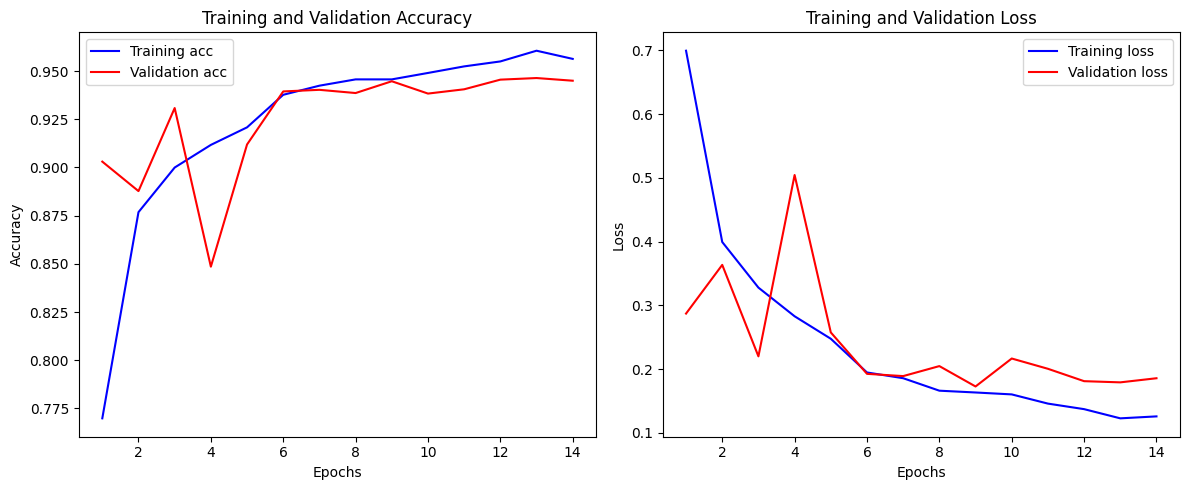

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


# predictions and confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

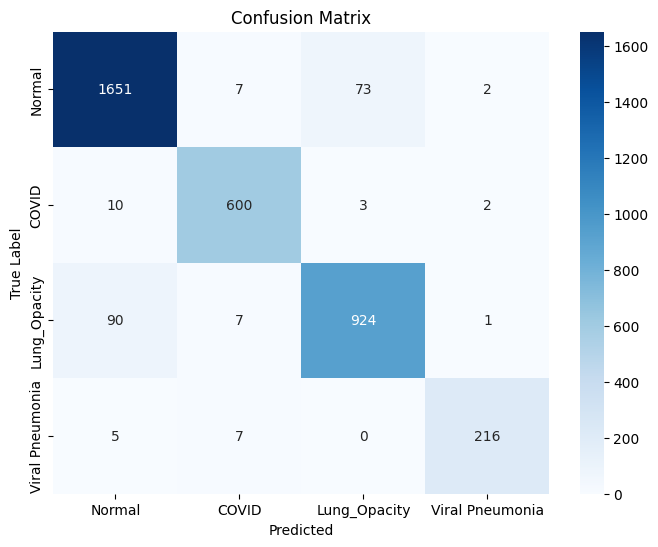

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Step 1: Get ground truth and predictions
y_true = []
y_pred = []

for (images, masks), labels in val_dataset_with_mask:
    preds = model.predict([images, masks])
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Step 2: Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#define gradcam

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_gradcam_grid_vgg(imgs, masks, model, last_conv_layer_name, n_images=15, rows=3, cols=5):
    plt.figure(figsize=(cols * 4, rows * 4))
    n_images = min(n_images, imgs.shape[0])

    for i in range(n_images):
        # Prepare model inputs
        img_input = np.expand_dims(imgs[i], axis=0)   # (1, 224, 224, 3)
        mask_input = np.expand_dims(masks[i], axis=0) # (1, 224, 224, 1)
        model_input = [img_input, mask_input]

        # Get Grad-CAM heatmap
        heatmap = get_gradcam_heatmap(model, model_input, last_conv_layer_name)

        # Overlay heatmap
        overlayed_img = overlay_heatmap(imgs[i], heatmap)

        # Plot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(overlayed_img[..., ::-1])  # Convert BGR to RGB
        plt.axis('off')
        plt.title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()



#gradcam on the vgg16 attention block

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Grad-CAM generator (already defined previously)
last_conv_layer_name = 'block5_conv3'

def get_gradcam_heatmap_multi_input(model, img_array, mask_array, last_conv_layer_name, pred_index=None):
    # Create a model that outputs the last conv layer and the predictions
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,  # Should be a list of input tensors
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass with both inputs
        conv_outputs, predictions = grad_model([img_array, mask_array])
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Calculate gradients of the target class wrt conv outputs
    grads = tape.gradient(class_channel, conv_outputs)

    # Average gradients spatially
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]  # Remove batch dim

    # Weighted combination of conv outputs channels by their gradients
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Relu on heatmap & normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-10)
    return heatmap.numpy()


# Overlay function (already defined previously)
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    if img.dtype != np.uint8:
        img_uint8 = np.uint8(255 * img)
    else:
        img_uint8 = img
    overlayed = cv2.addWeighted(heatmap_color, alpha, img_uint8, 1 - alpha, 0)
    return overlayed

# Main plotting function
def plot_gradcam_grid_vgg(X_test, test_masks, model, last_conv_layer_name, n_images=15, rows=3, cols=5):
    plt.figure(figsize=(cols * 4, rows * 4))

    n_images = min(n_images, X_test.shape[0])
    for i in range(n_images):
        img_input = np.expand_dims(X_test[i], axis=0)
        mask_input = np.expand_dims(test_masks[i], axis=0)
        # inputs = [img_input, mask_input]  # Not needed

        # Pass img_input and mask_input as separate arguments:
        heatmap = get_gradcam_heatmap_multi_input(model, img_input, mask_input, last_conv_layer_name)

        overlayed = overlay_heatmap(X_test[i], heatmap)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(overlayed[..., ::-1])  # Convert BGR to RGB
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()


# ======== Call the function ========
# Ensure model and test data are defined
last_conv_layer_name_model2 = 'block5_conv3'
plot_gradcam_grid_vgg(X_test, test_masks, model, last_conv_layer_name_model, n_images=15, rows=3, cols=5)



Output hidden; open in https://colab.research.google.com to view.